### `plot_smoothing_samples`
Plot some of the DUNEX wind data with examples of smoothing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# define some colors using palettes from ColorBrewer https://colorbrewer2.org/
grays = ['#f7f7f7','#cccccc','#969696','#636363','#252525']
blues = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
greens = ['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
windcol = ['#edf8fb','#b3cde3','#8c96c6','#8856a7','#810f7c']

# path to met station data
pathn = r'C:\\crs\\proj\\2019_DUNEX\\Pea_Island_Data\\06_metstation\\'
# met station
fn = 'Dunex_2021-09-13.csv'
# Hobo pressure logger
fnh = 'DUNEX_PI_baro1.csv'
# NWS Oregon Inlet met station
fnoi = 'ORIN7.csv'

# filename for output figure
figfn = 'DUNEX_met_station_plot.png'

# "Variable Name:","sequenceNumber","batteryVoltage","temperatureDatalogger","signalPercent","direction","direction","speed","speed","speed","airTemperature","relativeHumidity","rainfall"
# "Result Unit:","Dimensionless","volt","degreeCelsius","percent","degrees","degrees","metersPerSecond","metersPerSecond","metersPerSecond","degreeCelsius","percent","mm"

#### Read the met station `.csv` file using Pandas
Replace -9999 with NaNs, and and create a column with datetime objects

In [2]:
df = pd.read_csv(pathn+fn,skiprows=7,header=0,sep=',',na_values=[-9999])
df['dt'] = pd.to_datetime(df['Date and Time in UTC'], format='%Y-%m-%d %H:%M:%S')
df

,Date and Time in UTC,SampNum,Battery,BoardTemp,signalPercent,WXTDm,WXTDx,WXTSn,WXTSm,WXTSx,WXTTa,WXTUa,WXTRc,dt
0,2021-09-13 14:04:00,2.0,4.927,30.50,NaN,270.0,293.0,3.5,6.2,8.4,25.4,64.9,0.00,2021-09-13 14:04:00
1,2021-09-13 14:05:00,2.0,4.912,30.50,NaN,268.0,288.0,3.5,5.9,7.9,25.4,65.7,0.00,2021-09-13 14:05:00
2,2021-09-13 14:06:00,3.0,4.897,30.50,NaN,271.0,296.0,2.1,6.0,8.7,25.4,64.3,0.00,2021-09-13 14:06:00
3,2021-09-13 14:07:00,4.0,4.897,30.50,NaN,275.0,304.0,1.6,5.7,8.1,25.4,65.5,0.00,2021-09-13 14:07:00
4,2021-09-13 14:08:00,5.0,4.897,30.75,NaN,275.0,298.0,2.7,5.7,7.7,25.4,66.5,0.00,2021-09-13 14:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59383,2021-10-24 19:47:00,-6152.0,3.669,31.75,NaN,130.0,144.0,3.0,3.7,4.2,21.7,61.5,93.95,2021-10-24 19:47:00
59384,2021-10-24 19:48:00,-6151.0,3.669,31.75,NaN,128.0,143.0,3.0,3.6,4.1,21.7,62.0,93.95,2021-10-24 19:48:00
59385,2021-10-24 19:49:00,-6150.0,3.669,31.50,NaN,135.0,144.0,3.2,3.7,4.0,21.7,59.2,93.95,2021-10-24 19:49:00
59386,2021-10-24 19:50:00,-6149.0,3.669,31.50,NaN,135.0,149.0,2.3,3.4,4.1,21.7,59.8,93.95,2021-10-24 19:50:00


#### Magnetic declination  
from https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#declination  
for 35.677$^{\circ}$N, 75.480$^{\circ}$W on 9/30/2021:    
11.04$^{\circ}$West, changing by 0.01$^{\circ}$West per year  
$0.^{\circ}M = -11.04^{\circ}T$, so:  
$T = M + rot$ where $rot = -11.04$

In [3]:
rot = -11.04

#### Put the data into arrays and correct for mag. declination

In [4]:
dt = df['dt'].values
temp = df['WXTTa'].values
wspd_min = df['WXTSn'].values
wspd_mean = df['WXTSm'].values
wspd_max = df['WXTSx'].values

# correct for magnetic declination
wdir = df['WXTDm'].values + rot
wdir[wdir<0.]=wdir[wdir<0.]+360.

airT = df['WXTTa'].values
relh = df['WXTUa'].values
pptn = df['WXTRc'].values

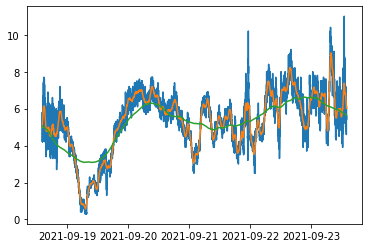

In [5]:
# this is a boxcar filter (moving mean) w points long.
# the 'same' mode means it returns a data array of the same length as the input.
# The other option is 'valid', which only returns valid data, but that removes w points from each end.
# It is always good to provide an odd number of points for w...that centers the values on a point, rather than between points
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

# hourly
wspd_smooth = moving_average(wspd_mean,61)
# daily
wspd_smooth2 = moving_average(wspd_mean,24*60+1)

# you might want to plot this at different scales to see detail.
#
npts = 60*120 # five days
ns = 7200
ne = ns+npts
plt.plot(dt[ns:ne],wspd_mean[ns:ne])
plt.plot(dt[ns:ne],wspd_smooth[ns:ne])
plt.plot(dt[ns:ne],wspd_smooth2[ns:ne])

C:\Users\CSHERW~1\AppData\Local\Temp\1/ipykernel_17424/2262762925.py:11: RuntimeWarning: invalid value encountered in remainder
  az = (az+360.)%360.


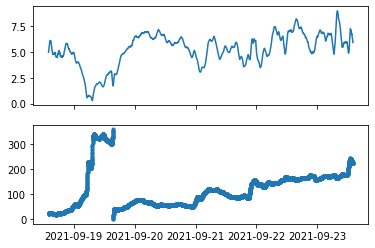

In [6]:
# You can't do the same with wind direction because of the wrap-around at 0 - 360.  
# You need to convert the speed-direction data to u- and v- components.
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az=np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

# convert from polar to x, y coordinates
u, v = xycoord(wspd_mean, wdir)
# smooth both
us = moving_average(u,61)
vs = moving_average(v,61)
# convert back to polar
wspd_smooth, wdir_smooth = pcoord( us, vs )

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(dt[ns:ne],wspd_smooth[ns:ne])
ax[1].plot(dt[ns:ne],wdir_smooth[ns:ne],'.')


In [7]:
# Some functions are non-linear, so you can't use convolve to apply them.
# You can do running *anything* using the approach here.
# (Replace np.nanstd, with, say np.nanmedian).

def running_stddev(y, npts):
    """
    Smooth a 1-d array w/ moving average of npts
    Return array of moving std. deviation
    https://stackoverflow.com/questions/40773275/sliding-standard-deviation-on-a-1d-numpy-array

    Input:
        y - 1-d array
        npts - number of points to average
    Returns:
        sy -  array of running std. deviation
    """
    sy = np.ones_like(y)*np.nan
    nrows = y.size - npts + 1
    n = y.strides[0]
    y2D = np.lib.stride_tricks.as_strided(y,shape=(nrows,npts),strides=(n,n))
    nclip = int((npts-1)/2)
    # print(nclip)
    sy[nclip:-nclip] = np.nanstd(y2D,1)
    return sy

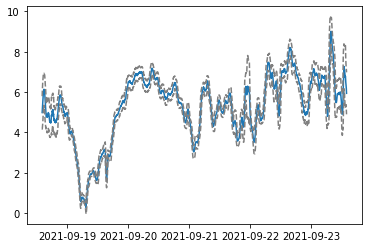

In [8]:
# calculate hourly standard deviation of wind speed
wspd_stddev = running_stddev(wspd_mean, 60+1)
plt.plot(dt[ns:ne],wspd_smooth[ns:ne])
plt.plot(dt[ns:ne],wspd_smooth[ns:ne]+wspd_stddev[ns:ne],'--',c='gray')
plt.plot(dt[ns:ne],wspd_smooth[ns:ne]-wspd_stddev[ns:ne],'--',c='gray')